In [212]:
import numpy as np
import matplotlib.pyplot as  plt
from tqdm import tqdm
from scipy.interpolate import interp1d

from np_fun import prob, prob_part
#from tf_fun import init as tf_init
from Annealing import Annealer

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
tst = lambda z,x: np.sin(z[0]*x+z[1])+z[0]+np.cos(2*z[1])+z[0]*z[1]
carr =lambda f,z: lambda x: f(z,x)
sampl = lambda f,fm=0,to=10,cnt=100: [np.linspace(fm,to,cnt),list(map(f,np.linspace(fm,to,cnt)))]

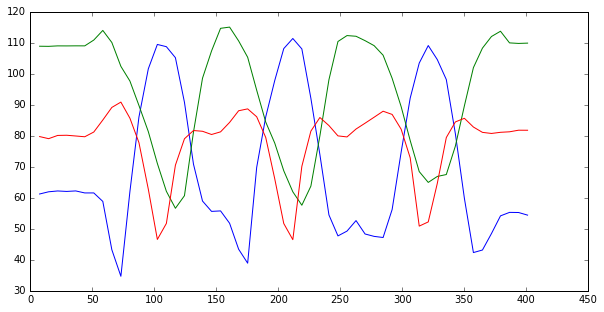

In [213]:
from numpy import genfromtxt
filenames = [
    './data_05-07-2018_20-20_port0.csv',
    './data_05-07-2018_20-30_port1.csv',
    './data_05-07-2018_20-20_port2.csv'
]
exp_points = [genfromtxt(i, delimiter=',') for i in filenames]
times = exp_points[0].T[1]
times_true = [ exp_points[i].T[1] for i in range(len(filenames))]
exp_points = np.array([i.T[0] for i in exp_points])
# plot the data
plt.figure(figsize=(10,5))
for i in exp_points:
    plt.plot(times,i)

### period is approx 120 sec, ampl 110-40=70, mean min is 43

1.3722753337869233
Data points used: 35


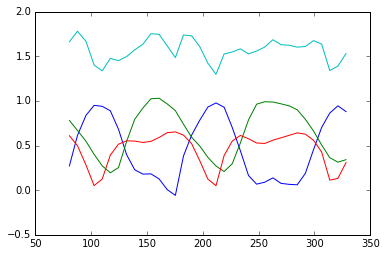

In [242]:
me_min, ampl, per = 43, 110-40, 120
start_exp, end_exp = 10, 45
data = exp_points[:, start_exp:end_exp]
pts = times[start_exp:end_exp]#-times[start_exp]
pts_true = [ times_true[i][start_exp:end_exp] for i in range(len(filenames))]

data = data - me_min
data /= ampl 
#pts = pts/120*2*np.pi
for i in data:
    plt.plot(pts,i)
s= np.sum(data,axis=0)
print(max(s)/min(s))
plt.plot(pts,np.sum(data,axis=0))
l = len(pts)
print('Data points used:',l)

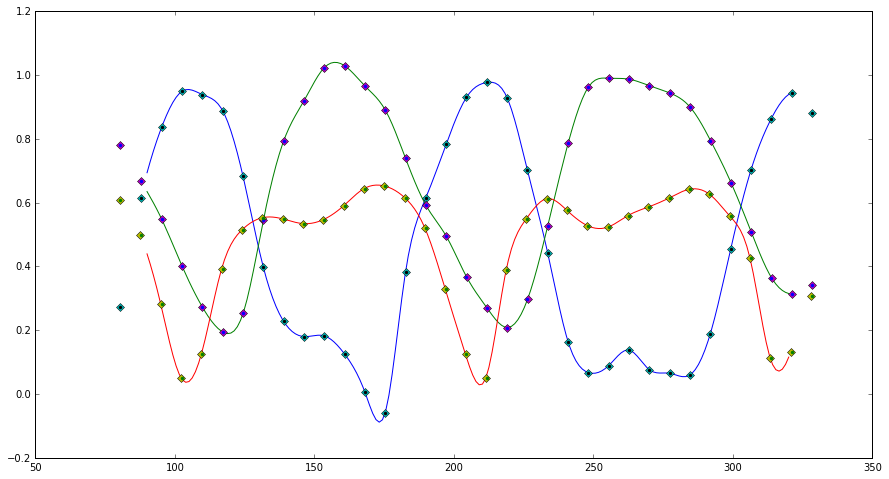

In [256]:
f = []
for i in range(len(data)):
    f.append(interp1d(pts_true[i], data[i], kind='cubic'))
    
x_new = np.linspace(90,320,200)
plt.figure(figsize=(15,8))
for i in f:
    plt.plot(x_new,i(x_new))
for i in range(len(data)):
    plt.plot(pts_true[i],data[i],'D')
for i in data:
    plt.plot(pts,i,'.')

[7.269330000000001, 7.305429999999998, 7.280360000000002, 7.280360000000002, 7.279669999999996, 7.281320000000001, 7.271329999999999, 7.297410000000006, 7.284369999999996, 7.2813600000000065, 7.2803599999999875, 7.280360000000002, 7.280360000000002, 7.275370000000009, 7.297369999999987, 7.28237, 7.269360000000006, 7.2843400000000145, 7.281359999999978, 7.2813600000000065, 7.292390000000012, 7.287379999999985, 7.274339999999995, 7.286380000000008, 7.274339999999995, 7.28537, 7.295400000000001, 7.27534, 7.279359999999997, 7.285420000000016, 7.280319999999989, 7.2803499999999985, 7.275350000000003, 7.299409999999995, 7.276369999999986, 7.2773200000000315, 7.2763499999999794, 7.290390000000002, 7.279359999999997, 7.292390000000012, 7.283399999999972, 7.270290000000045, 7.290390000000002, 7.280359999999973, 7.277339999999981, 7.297420000000045, 7.280389999999954, 7.276310000000024, 7.284370000000024, 7.283359999999959, 7.26836000000003, 7.302390000000003, 7.275350000000003, 7.28837999999996

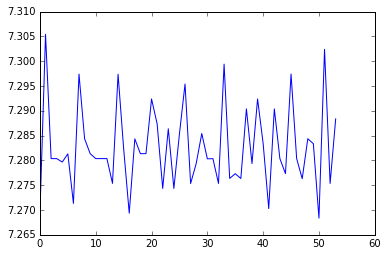

In [255]:

deltas = []
n =2
for i in range(len(times_true[n])-1):
    deltas.append(times_true[n][i+1] - times_true[n][i])
print(deltas)
plt.plot(deltas)

[array([  7.58417,  14.85755,  22.14394,  29.43729,  36.71367,  44.00005,
        51.2754 ,  58.55873,  65.8391 ,  73.13051,  80.4159 ,  87.68823,
        95.25633, 102.54471, 109.81708, 117.10444, 124.39783, 131.67923,
       138.95855, 146.26297, 153.51932, 160.79963, 168.09002, 175.37039,
       182.64877, 189.92813, 197.21649, 204.48885, 211.79325, 219.0726 ,
       226.35297, 233.62531, 240.91369, 248.18606, 255.48749, 262.76182,
       270.04817, 277.32658, 284.59686, 291.87622, 299.17216, 306.45252,
       313.73188, 321.01224, 328.2916 , 335.57196, 342.86736, 350.14772,
       357.42808, 364.70945, 371.9868 , 379.26816, 386.54853, 393.84393,
       401.12329]), array([  7.46352,  14.87927,  22.17669,  29.45705,  36.73642,  44.01677,
        51.29713,  58.58451,  65.8729 ,  73.15225,  80.43262,  87.70795,
        95.28106, 102.56046, 109.83677, 117.13622, 124.41658, 131.69694,
       138.97225, 146.25666, 153.55307, 160.82741, 168.11279, 175.39211,
       182.67749, 189.94885, 1

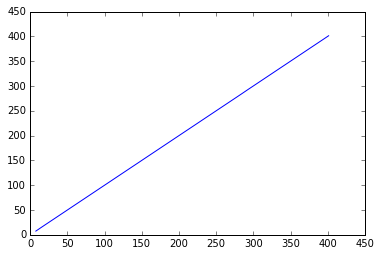

In [251]:
#plt.acorr(data[0])
print(times_true)

plt.plot(times_true[0],times_true[1])
print(times_true[0]-times_true[1],times_true[0]-times_true[2])

[ 0.          0.07503429  0.15006857  0.22510286  0.30013714  0.37517143
  0.45020572  0.52524     0.60027429  0.67530858  0.75034286  0.82537715
  0.90041143  0.97544572  1.05048001  1.12551429  1.20054858  1.27558287
 -1.27558287 -1.20054858 -1.12551429 -1.05048001 -0.97544572 -0.90041143
 -0.82537715 -0.75034286 -0.67530858 -0.60027429 -0.52524    -0.45020572
 -0.37517143 -0.30013714 -0.22510286 -0.15006857 -0.07503429]


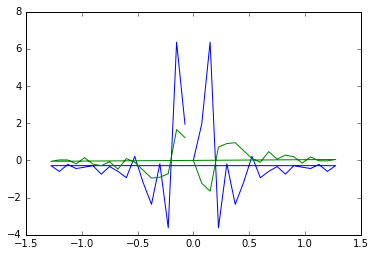

In [153]:
ft = np.fft.fft(data[0]-np.mean(data[0]))
freq = np.fft.fftfreq(ft.shape[-1],d=pts[1])
plt.plot(freq,ft.real)
plt.plot(freq,ft.imag)
print(freq)

120 11.668611435239207


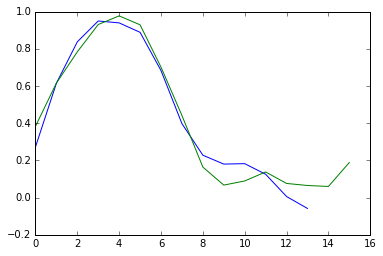

In [154]:
#### per = 1/0.15006
units_period = 1/0.0857
print(per,units_period)
plt.plot(data[0][:14])
plt.plot(data[0][14:30])


In [155]:

data = np.array([data[2]])      
print(data)

[[0.60967786 0.49728171 0.28231129 0.05094571 0.12473343 0.39318414
  0.51489771 0.55289457 0.54942557 0.534572   0.54678286 0.59029286
  0.64398643 0.65260914 0.61632757 0.52117314 0.33033471 0.12433857
  0.04990571 0.38788957 0.55015571 0.612885   0.575728   0.52819886
  0.52338229 0.55975114 0.58659957 0.614071   0.64185057 0.62705971
  0.55872471 0.42692314 0.11239671 0.13175429 0.30890429]]


(100,) (3, 100)


/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


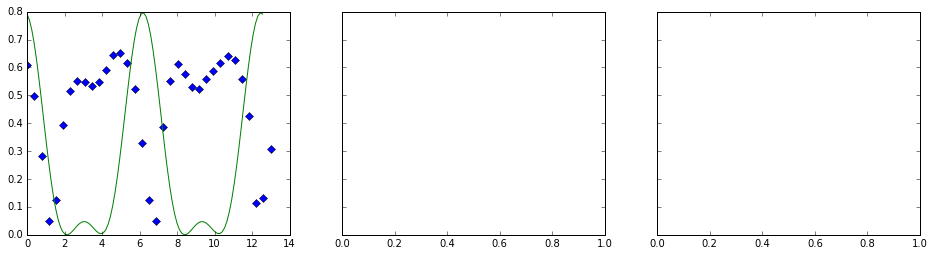

In [157]:
def func(x):
    return np.abs(np.square(prob_part(0,0,0,0,phi=x)))
def plot3(func,on_same=False,data_len=3):
    lin,d = sampl(func,0,12.56,100)
    d = np.array(d).T
    %matplotlib inline
    fs=(16,4)
    if on_same:
        plt.figure(figsize=fs)
        ax =[plt,plt,plt]
    else:
        f,ax = plt.subplots(1,3,figsize=fs,sharey=True)
    for i in range(data_len):
        ax[i].plot(pts,data[i],'D',label='data%i'%i)
        print(lin.shape,d.shape)
        ax[i].plot(lin,d[i],label='func%i'%i)
    plt.legend()
plot3(func,on_same=False,data_len=1)

In [158]:
data


array([[0.60967786, 0.49728171, 0.28231129, 0.05094571, 0.12473343,
        0.39318414, 0.51489771, 0.55289457, 0.54942557, 0.534572  ,
        0.54678286, 0.59029286, 0.64398643, 0.65260914, 0.61632757,
        0.52117314, 0.33033471, 0.12433857, 0.04990571, 0.38788957,
        0.55015571, 0.612885  , 0.575728  , 0.52819886, 0.52338229,
        0.55975114, 0.58659957, 0.614071  , 0.64185057, 0.62705971,
        0.55872471, 0.42692314, 0.11239671, 0.13175429, 0.30890429]])

In [159]:
fixed = [0,0]
#data = data[2]
tst = lambda z,x: np.sin(z[0]*x+z[1])+z[0]+np.cos(2*z[1])+z[0]*z[1]
carr =lambda f,z: lambda x: f(z,x)
sampl_map_depr = lambda f,fm=0,to=10,cnt=100: [np.linspace(fm,to,cnt),list(map(f,np.linspace(fm,to,cnt)))]
sampl = lambda f,fm=0,to=10,cnt=100: [np.linspace(fm,to,cnt),f(np.linspace(fm,to,cnt))]
np_map = lambda f,x: np.array(list(map(f, x)))

device = lambda z,x:np.abs(np.square(prob_part(z[0],z[1],fixed[0],fixed[1],phi=x)))
unit = lambda z,x: device(z,x).dot(np.array([0,1,0]).T)
cost = lambda f,data,points=pts: np.sum(np.square(f(points).T-data))
foo = lambda x: unit([0,0],x)

ttt = carr(unit,[0,0])
print(ttt(pts))
cost(carr(unit,[0,0]),data[0],pts)


[6.45591224e-03 7.86564957e-02 2.49524750e-01 4.74975989e-01
 6.88865384e-01 8.14051951e-01 8.01399347e-01 6.56082511e-01
 4.34206631e-01 2.14414239e-01 6.37662708e-02 3.24358986e-03
 1.02451567e-02 3.62956565e-02 4.10657846e-02 1.83899933e-02
 1.34068478e-04 3.58149322e-02 1.60078642e-01 3.64022838e-01
 5.93566476e-01 7.69571953e-01 8.25711322e-01 7.39766782e-01
 5.44638107e-01 3.14497246e-01 1.24811257e-01 2.13344589e-02
 1.31016077e-03 2.45462133e-02 4.28046452e-02 3.13750015e-02
 5.20474439e-03 9.13481285e-03 8.87843234e-02]


5.526377239404564

In [108]:
def get_parametric(func,dots=50):
    xrange = np.linspace(-7.0, 7.0, dots)
    yrange = np.linspace(-7.0, 7.0, dots)
    p = np.zeros((len(xrange),len(yrange)))
    f2d = lambda x,y:cost(carr(func,[x,y]),data)
    #f2d = lambda x,y:opt.prob(x,y,12)
    for x in tqdm(range(len(xrange))):
        for y in range(len(yrange)):
            p[y,x] =  f2d(xrange[x],yrange[y])
    return xrange,yrange,p

def display_parametric(p):
    best_pos=np.unravel_index( np.argmin(p),p.shape)
    best_pos = [xrange[best_pos[0]], yrange[best_pos[1]]]
    print("Min cost is:",np.min(p),' at position ',best_pos)
    
    %matplotlib notebook
    plt.contourf(xrange,yrange,p,100)
    #plt.savefig('fig.png',dpi=300)
xrange,yrange,p = get_parametric(device)
print()

100%|██████████| 50/50 [00:01<00:00, 42.05it/s]

In [109]:
best_pos=np.unravel_index( np.argmin(p),p.shape)
best_pos = [xrange[best_pos[1]], yrange[best_pos[0]]]
print("Min cost is:",np.min(p),' at position ',best_pos)

Min cost is: 8.049241679176921  at position  [0.14285714285714235, -3.285714285714286]


/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


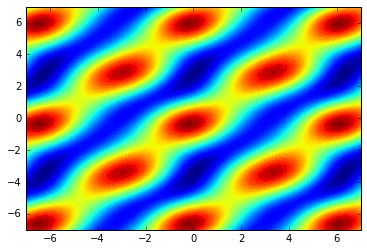

In [110]:

%matplotlib inline
plt.contourf(xrange,yrange,p,50)

#plt.scatter(*np.array(opt.dots).T,c=np.arange(len(opt.dots)),marker='o',alpha=0.7)
#plt.savefig('fig.png',dpi=300)

In [135]:

point = [-0.5,2.52]
point = best_pos
fun = carr(device,point)
print('cost is ',cost(fun,data))
plot3(fun)
#plt.figure(figsize=(15,5))
#plt.plot(pts,data[1],'D')
#plt.plot(*sampl(carr(unit,point),0,14))

TypeError: 'numpy.float64' object is not callable

In [136]:
kek = carr(device,[0,0])
carr_dev = lambda x,y:carr(device,[x,y])
print("cost",cost(carr_dev(0,0),data))
plot3(kek,data_len=1)

TypeError: 'numpy.float64' object is not callable

In [143]:

func = lambda x: np.array([0.1,0,0.5]*len(x)).reshape(len(x),3)

print(func(np.array([2,3])))
print("cost",cost(func,data))
t_data = data[:,:]
#t_data[2,:]-=0.5
print("sumsq:",np.sum(np.square(data)))
plot3(func,data_len=1)


[[0.1 0.  0.5]
 [0.1 0.  0.5]]


TypeError: 'numpy.float64' object is not callable

### Optimisation


In [200]:
unit_all = lambda z,x: np.abs(np.square(prob_part(z[0],z[1],z[2],z[3], phi=z[4]*x+z[5]))).dot(np.array([0,0,1])).T*z[6]+z[7]
#unit_all = lambda z,x: unit_all_l(z,x).T.dot(np.array([0,0,1]))
cc = carr(unit_all,[0,0,0,0,0,0,0,0])
print(cc(np.array([1,12])))

opt = Annealer(unit_all,points_data=(pts,data),energy=0.9)
cost(cc,data[0],pts)

[0. 0.]


TypeError: 'numpy.float64' object is not callable

In [208]:
start = [0,0,0,0,1,0,1,0]
#start = [0,0,0,0,-1,60,1.5,0]
#start = [8.805,-5.11,9.458,6.987,-1,20,1.5,0]
scales= np.array([1,1,1,1,0.2,1.5,0.4,0.3])*0.8
point,cost = opt.opt(start_point=start,
                     scales = scales,
                     max_steps =10000
                    )

print(point,cost)
print(opt.best)

100%|█████████▉| 9988/10000 [00:12<00:00, 773.04it/s]/home/danlkv/quantTechLab/Fit/Annealing.py:18: RuntimeWarning: overflow encountered in exp
  self.prob = lambda e,e_,t: 1/(1+np.exp(-((e-e_)*(1+0.1*np.heaviside(e_-e,0))/self.energy-0.3/t)))
100%|██████████| 10000/10000 [00:12<00:00, 772.64it/s]

[-30.88783501 -21.35574436  -1.37030883  15.81340682   3.12812009
  25.95038131   0.49913637   0.44284077] 10.824642801100275
[-5.73105842 -6.08928021  8.44223281  9.59930356  1.0899133  13.65899868
 -0.09242813  0.5519288 ]


8.796691899090366


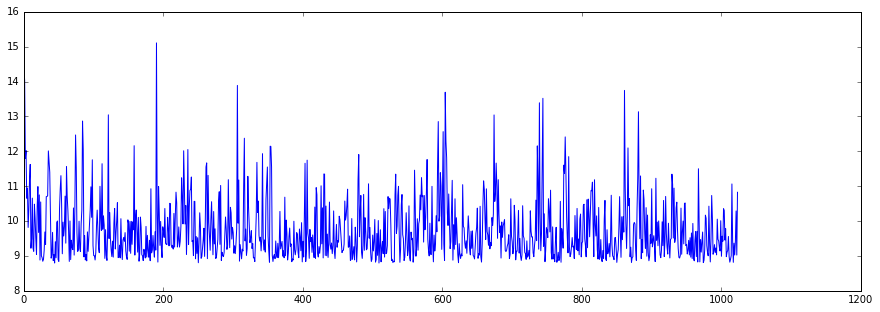

In [209]:
plt.figure(figsize=(15,5))
plt.plot(opt.costs)
print(np.min(opt.costs))

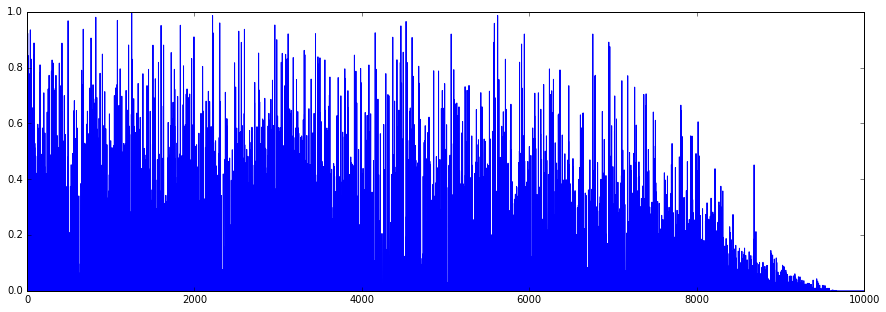

In [210]:

plt.figure(figsize=(15,5))
plt.plot(opt.probs)

(100,) (1, 100)


/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


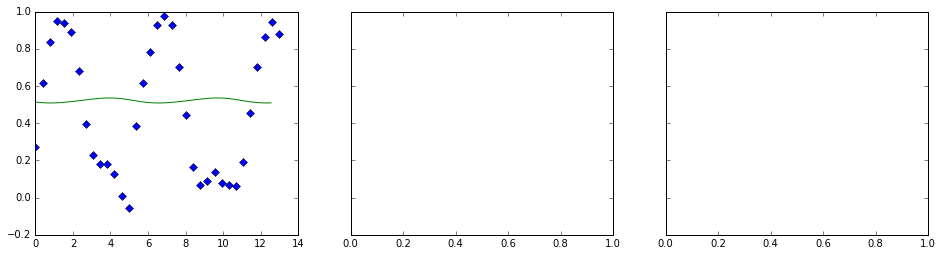

In [211]:
%matplotlib inline
best_fun= carr(unit_all,opt.best)
plot3(lambda x: np.array([best_fun(x)]).reshape(-1,1),data_len=1)